This code extracts the spike times associated with particular tracks in the shortcut experiment. First, import all necessary packages -- including vdmlab. This includes an "info" file that contains session-specific information.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

import vdmlab as vdm

from load_data import get_pos, get_spikes
from maze_functions import spikes_by_position
from plotting_functions import plot_intersects, plot_zone

import sys
sys.path.append('E:\\code\\python-vdmlab\\projects\\emily_shortcut\\info')
import info.R063d2_info as r063d2
import info.R063d3_info as r063d3
import info.R063d4_info as r063d4
import info.R063d5_info as r063d5
import info.R063d6_info as r063d6
import info.R066d1_info as r066d1
import info.R066d2_info as r066d2
import info.R066d4_info as r066d4
import info.R067d1_info as r067d1
import info.R067d2_info as r067d2
import info.R067d3_info as r067d3

import info.R068d1_info as r068d1

In [2]:
# output_path = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\matlab\\spike_pos\\'
output_path = 'E:\\code\\emi_shortcut\\cache\\matlab\\spike_pos\\'
info = r067d2

In [3]:
pos = get_pos(info.pos_mat, info.pxl_to_cm)
spikes = get_spikes(info.spike_mat)

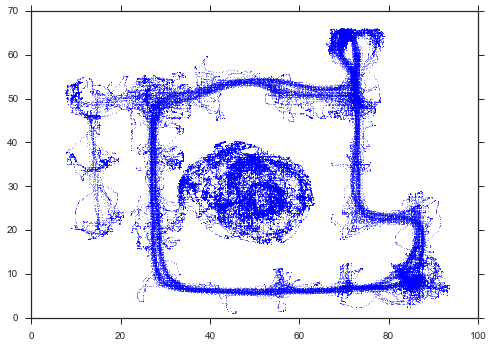

In [4]:
# Plot to check
plt.plot(pos.x, pos.y, 'b.', ms=1)
plt.show()

## Constructing track specifics
Here, we specify the ideal linear trajectorys, and expand those linear lines to zones by about the track width, which includes the rat positions.

In [8]:
u_line = LineString(info.u_trajectory)
shortcut_line = LineString(info.shortcut_trajectory)
novel_line = LineString(info.novel_trajectory)

expand_by = 2

u_start = Point(info.u_trajectory[0])
u_stop = Point(info.u_trajectory[-1])
shortcut_start = Point(info.shortcut_trajectory[0])
shortcut_stop = Point(info.shortcut_trajectory[-1])
novel_start = Point(info.novel_trajectory[0])
novel_stop = Point(info.novel_trajectory[-1])
pedestal_center = Point(info.path_pts['pedestal'][0], info.path_pts['pedestal'][1])
pedestal = pedestal_center.buffer(expand_by*2.2)

In [9]:
zone = dict()
zone['u'] = vdm.expand_line(u_start, u_stop, u_line, expand_by)
zone['shortcut'] = vdm.expand_line(shortcut_start, shortcut_stop, shortcut_line, expand_by)
zone['novel'] = vdm.expand_line(novel_start, novel_stop, novel_line, expand_by)
zone['ushort'] = zone['u'].intersection(zone['shortcut'])
zone['unovel'] = zone['u'].intersection(zone['novel'])
zone['uped'] = zone['u'].intersection(pedestal)
zone['shortped'] = zone['shortcut'].intersection(pedestal)
zone['novelped'] = zone['novel'].intersection(pedestal)
zone['pedestal'] = pedestal

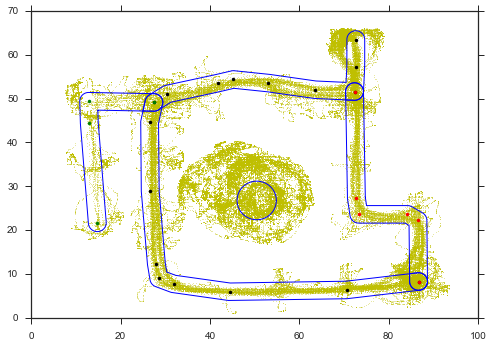

In [10]:
plt.plot(pos.x, pos.y, 'y.', ms=1)
plt.plot(u_line.xy[0], u_line.xy[1], 'k.')
plt.plot(shortcut_line.xy[0], shortcut_line.xy[1], 'r.')
plt.plot(novel_line.xy[0], novel_line.xy[1], 'g.')
for zones in zone:
    if zone[zones].geom_type == 'MultiPolygon':
        plot_intersects(zone[zones])
    elif zone[zones].geom_type == 'Polygon':
        plot_zone(zone[zones])
    else:
        continue

Below checks that the positions can be separated by zones. Just a proof-of-concept, this output is not used in the analysis but it is related to how we sort the spikes times later. 

In [ ]:
u_idx = []
shortcut_idx = []
novel_idx = []
ped_idx = []
other_idx = []
for pos_idx in range(len(pos.time)):
    point = Point([pos.x[pos_idx], pos.y[pos_idx]])
    if pedestal.contains(point) or zone['uped'].contains(point) or zone['shortped'].contains(point) or zone['novelped'].contains(point):
        ped_idx.append(pos_idx)
        continue
    elif zone['u'].contains(point) or zone['ushort'].contains(point) or zone['unovel'].contains(point):
        u_idx.append(pos_idx)
        continue
    elif zone['shortcut'].contains(point):
        shortcut_idx.append(pos_idx)
        continue
    elif zone['novel'].contains(point):
        novel_idx.append(pos_idx)
        continue
    else:
        other_idx.append(pos_idx)

In [ ]:
u_pos = pos[u_idx]
shortcut_pos = pos[shortcut_idx]
novel_pos = pos[novel_idx]
ped_pos = pos[ped_idx]
other_pos = pos[other_idx]

plt.plot(u_pos.x, u_pos.y, 'b.')
plt.plot(shortcut_pos.x, shortcut_pos.y, 'g.')
plt.plot(novel_pos.x, novel_pos.y, 'r.')
plt.plot(ped_pos.x, ped_pos.y, 'm.')
plt.plot(other_pos.x, other_pos.y, 'k.')
plt.show()

In [ ]:
print(len(other_pos['time'])) # Want minimum number of spikes in this category, essentially unaccounted for.

## Finished! 
Ready to use in *track_spikes.py* and/or *shortcut_behavior.py*